

---
# **Genetic Algorithm-Based Feature Selection and Model Comparison Across Cross-Validation Strategies for Regression Performance Optimization**
---



# Import relevant libraries

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
import joblib
from math import pi
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')



# Import the dataset with 70/30 Train/Test split

In [2]:
# Load data
Path_Data = '3_merged_data3.txt'
df = pd.read_csv(Path_Data, sep='\t')

# Prepare data
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

# There is no need for validation split as after this we will be performing k-fold on
# training data which wil auto account the validation part

## The test dataset will be used to evaluate the quality of our trained model

Shape of X_train: (119, 33048)
Shape of X_test: (30, 33048)


# Set Parameters and Models

In [17]:
models = {
    'DecisionTree': DecisionTreeRegressor(),
    #'RandomForest': RandomForestRegressor(n_jobs=2),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
    #'LassoRegression': Lasso(),
}

# ^^^^ The code is modular enough to add any type of regression model to test and compare its accuracy against others^^^^ #

k_values = [3, 5] # I used 2 for simplicity. If more accuracy is to be tested, this can be increased

population_size = 20
mutation_rate = 0.1
num_generations = 10

# Genetic Algo functions

In [18]:
def initialize_population():
    np.random.seed(42)
    population = []
    for _ in range(population_size):
        features = np.random.randint(2, size=X_train.shape[1])
        population.append(features)
    return population

def decode_individual(individual):
    return individual.astype(int)

def fitness_function(individual, model, kfold):
    features = decode_individual(individual)
    selected_cols = [i for i, bit in enumerate(features) if bit == 1]
    if len(selected_cols) == 0:
        return np.inf
    X_selected = X_train.iloc[:, selected_cols]
    scores = -1 * cross_val_score(model, X_selected, y_train, cv=kfold,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()

def selection(population, scores):
    selected = []
    for _ in range(len(population)):
        i1, i2 = random.sample(range(len(population)), 2)
        selected.append(population[i1] if scores[i1] < scores[i2] else population[i2])
    return selected

def crossover(p1, p2):
    split_point = random.randint(1, len(p1) - 1)
    child1 = np.concatenate((p1[:split_point], p2[split_point:]))
    child2 = np.concatenate((p2[:split_point], p1[split_point:]))
    return child1, child2

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

# Training and saving the relevant models

In [19]:
# Create directory if not exists
save_dir = "saved_models_genetic"
os.makedirs(save_dir, exist_ok=True)

results = []

for model_name, model in models.items():
    for k in k_values:
        print(f"\nRunning GA for {model_name} with k={k} folds CV")
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        population = initialize_population()

        gen_mse_progress = []

        for gen in tqdm(range(num_generations), desc=f"GA {model_name} k={k}"):
            scores = [fitness_function(ind, model, kfold) for ind in population]
            gen_mse_progress.append(np.min(scores))
            sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
            population = sorted_pop[:population_size//2]

            next_gen = population.copy()
            while len(next_gen) < population_size:
                p1, p2 = random.sample(population, 2)
                c1, c2 = crossover(p1, p2)
                next_gen.append(mutate(c1))
                if len(next_gen) < population_size:
                    next_gen.append(mutate(c2))
            population = next_gen

        best_individual = sorted(population, key=lambda ind: fitness_function(ind, model, kfold))[0]
        best_features = decode_individual(best_individual)
        selected_cols = [i for i, bit in enumerate(best_features) if bit == 1]

        if len(selected_cols) == 0:
            print("Warning: No features selected, skipping this configuration.")
            continue

        model.fit(X_train.iloc[:, selected_cols], y_train)
        y_pred = model.predict(X_test.iloc[:, selected_cols])

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv_mse = fitness_function(best_individual, model, kfold)

        results.append({
            'Model': model_name,
            'K_Folds': k,
            'CV_MSE': cv_mse,
            'Test_MSE': mse,
            'Test_MAE': mae,
            'Test_R2': r2,
            'Num_Features': len(selected_cols),
            'MSE_Progress': gen_mse_progress
        })

        model_filename = f"{model_name}_k{k}_best_model.joblib"
        model_path = os.path.join(save_dir, model_filename)
        joblib.dump({
            'model': model,
            'selected_features': selected_cols
        }, model_path)

        print(f"Saved best model for {model_name} with k={k} at {model_path}")

summary_df = pd.DataFrame(results)
print("\nSummary:\n", summary_df)


Running GA for DecisionTree with k=3 folds CV


GA DecisionTree k=3: 100%|██████████| 10/10 [03:22<00:00, 20.22s/it]


Saved best model for DecisionTree with k=3 at saved_models_genetic/DecisionTree_k3_best_model.joblib

Running GA for DecisionTree with k=5 folds CV


GA DecisionTree k=5: 100%|██████████| 10/10 [05:50<00:00, 35.02s/it]


Saved best model for DecisionTree with k=5 at saved_models_genetic/DecisionTree_k5_best_model.joblib

Running GA for GradientBoosting with k=3 folds CV


GA GradientBoosting k=3: 100%|██████████| 10/10 [42:07<00:00, 252.71s/it]


Saved best model for GradientBoosting with k=3 at saved_models_genetic/GradientBoosting_k3_best_model.joblib

Running GA for GradientBoosting with k=5 folds CV


GA GradientBoosting k=5: 100%|██████████| 10/10 [1:18:30<00:00, 471.01s/it]


Saved best model for GradientBoosting with k=5 at saved_models_genetic/GradientBoosting_k5_best_model.joblib

Running GA for LinearRegression with k=3 folds CV


GA LinearRegression k=3: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]


Saved best model for LinearRegression with k=3 at saved_models_genetic/LinearRegression_k3_best_model.joblib

Running GA for LinearRegression with k=5 folds CV


GA LinearRegression k=5: 100%|██████████| 10/10 [05:17<00:00, 31.80s/it]


Saved best model for LinearRegression with k=5 at saved_models_genetic/LinearRegression_k5_best_model.joblib

Summary:
               Model  K_Folds    CV_MSE  Test_MSE  Test_MAE   Test_R2  \
0      DecisionTree        3  2.645170  3.669573  1.511333 -1.663433   
1      DecisionTree        5  2.786008  3.369680  1.439333 -1.445766   
2  GradientBoosting        3  1.565129  1.377243  0.933755  0.000375   
3  GradientBoosting        5  1.601346  1.320379  0.907725  0.041648   
4  LinearRegression        3  1.668040  1.585225  1.075081 -0.150581   
5  LinearRegression        5  1.945646  1.772289  1.139144 -0.286355   

   Num_Features                                       MSE_Progress  
0         16501  [2.6031573931623933, 2.620300128205128, 2.6606...  
1         16484  [2.9829915942028986, 2.8702955072463774, 2.676...  
2         16474  [1.666060750419233, 1.6496681908024773, 1.6324...  
3         16529  [1.6949829978801247, 1.694013327280978, 1.6836...  
4         16430  [2.0049937189

In [20]:
# Save the summary results to a CSV file
summary_csv_path = 'model_comparison_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"\nSummary saved to: {summary_csv_path}")


Summary saved to: model_comparison_summary.csv


# Test the models and pick the best amongst them

In [21]:
# Choose metric to pick best model
# For MSE lower is better, for R2 higher is better
metric = 'Test_MSE'  # or 'Test_R2'

# Find the best row based on metric
if metric == 'Test_MSE':
    best_idx = summary_df[metric].idxmin()
elif metric == 'Test_R2':
    best_idx = summary_df[metric].idxmax()
else:
    raise ValueError("Unsupported metric for selection")

best_model_info = summary_df.loc[best_idx]
model_name = best_model_info['Model']
k = best_model_info['K_Folds']

print(f"Best model by {metric}: {model_name} with k={k}")

# Build the path to the saved model file
model_filename = f"{model_name}_k{k}_best_model.joblib"
model_path = os.path.join("saved_models_genetic", model_filename)

# Load model and selected features
loaded_data = joblib.load(model_path)
loaded_model = loaded_data['model']
selected_features = loaded_data['selected_features']

print(f"Loaded model: {loaded_model}")
print(f"Selected features count: {len(selected_features)}")

# Run inference on test set with selected features
X_test_selected = X_test.iloc[:, selected_features]
y_pred = loaded_model.predict(X_test_selected)

# Calculate performance metrics on test set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nPerformance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Show 10 predictions and their corresponding true values side-by-side
comparison_df = pd.DataFrame({
    'Predicted': y_pred[:10],
    'Actual': y_test.iloc[:10].values
})

print("\nSample Predictions vs Actual Values:")
print(comparison_df)

Best model by Test_MSE: GradientBoosting with k=5
Loaded model: GradientBoostingRegressor()
Selected features count: 16529

Performance on Test Set:
Mean Squared Error (MSE): 1.3204
Mean Absolute Error (MAE): 0.9077
R-squared (R2): 0.0416

Sample Predictions vs Actual Values:
   Predicted  Actual
0   4.552528    4.67
1   4.151343    5.00
2   3.471254    2.33
3   3.074736    3.33
4   3.412420    5.00
5   4.634447    6.00
6   4.792184    4.33
7   4.566938    3.33
8   4.701645    5.33
9   3.624497    6.83




---
# Visualisations
---



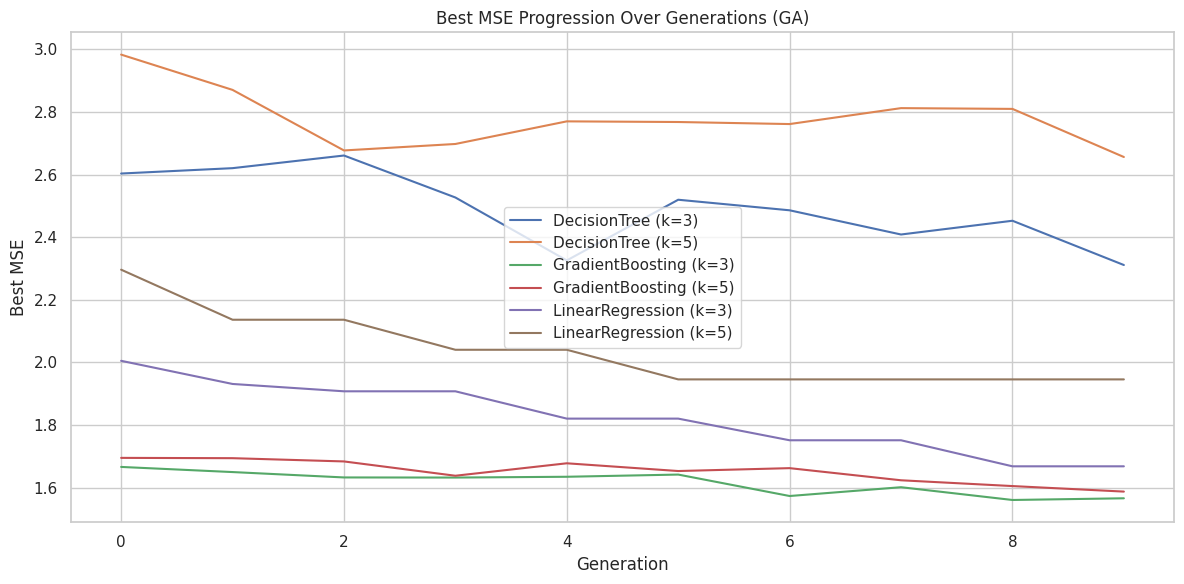

In [22]:
# Visualizations
sns.set(style="whitegrid")

# 1. MSE Line Plot over Generations
plt.figure(figsize=(12, 6))
for row in results:
    label = f"{row['Model']} (k={row['K_Folds']})"
    plt.plot(row['MSE_Progress'], label=label)
plt.title("Best MSE Progression Over Generations (GA)")
plt.xlabel("Generation")
plt.ylabel("Best MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

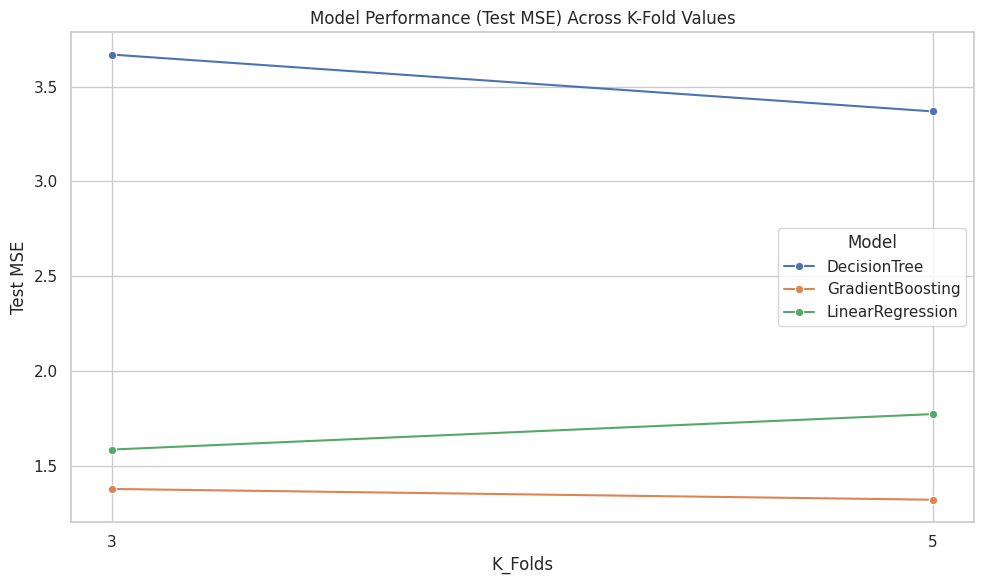

In [31]:
# 2. Model Performance (Test MSE) Across K-Fold Values
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_df, x='K_Folds', y='Test_MSE', hue='Model', marker='o')
plt.title('Model Performance (Test MSE) Across K-Fold Values')
plt.ylabel('Test MSE')
plt.xticks(summary_df['K_Folds'].unique())
plt.tight_layout()
plt.show()


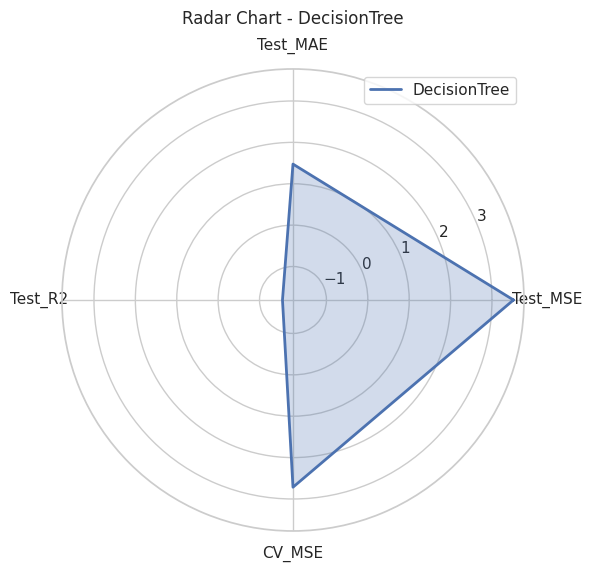

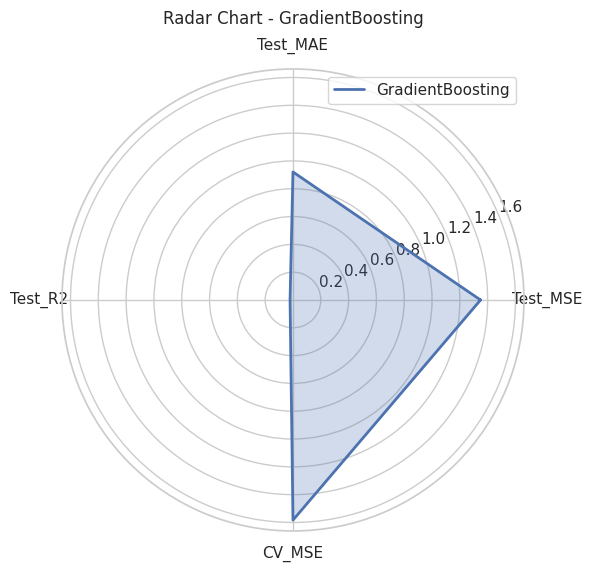

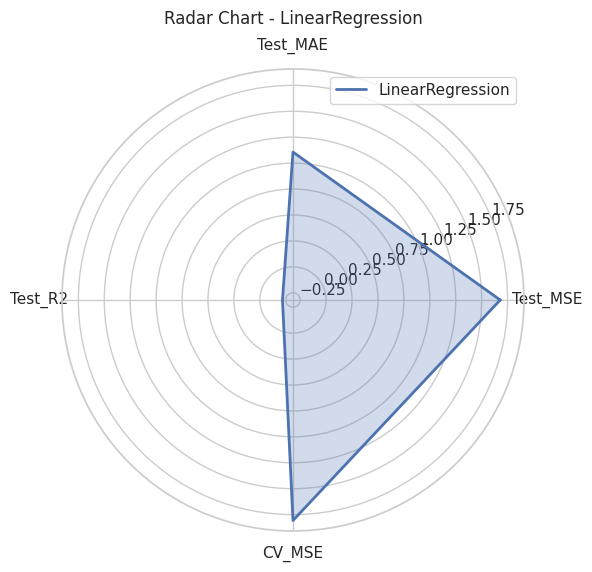

In [24]:
# 3. Radar Plot (Spider Chart) per Model
def plot_radar_for_model(df, model_name):
    df_model = df[df['Model'] == model_name].mean(numeric_only=True)
    metrics = ['Test_MSE', 'Test_MAE', 'Test_R2', 'CV_MSE']
    values = df_model[metrics].values.tolist()
    values += values[:1]  # loop back to start
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], metrics)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
    ax.fill(angles, values, alpha=0.25)
    plt.title(f'Radar Chart - {model_name}', y=1.08)
    plt.legend()
    plt.show()

for model in summary_df['Model'].unique():
    plot_radar_for_model(summary_df, model)

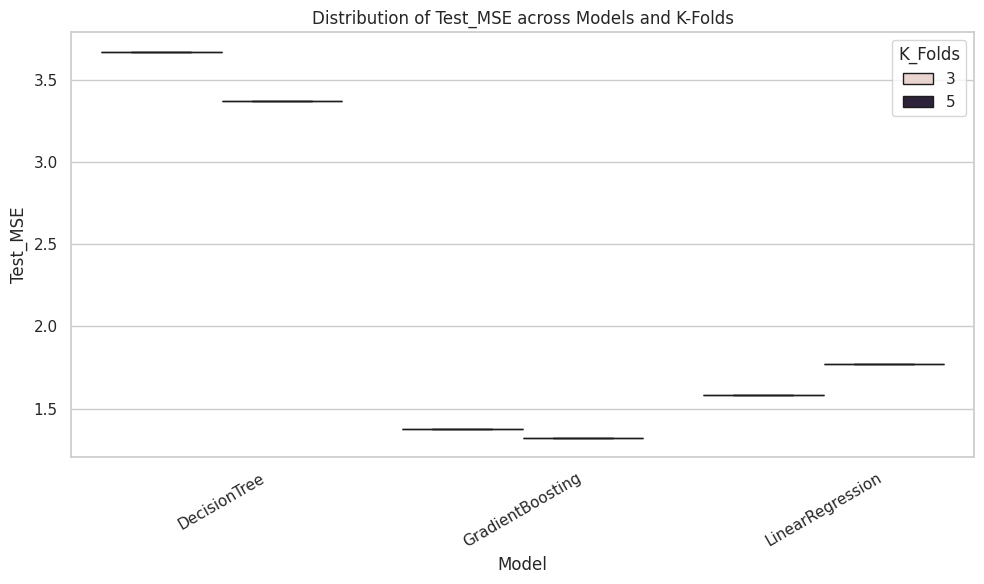

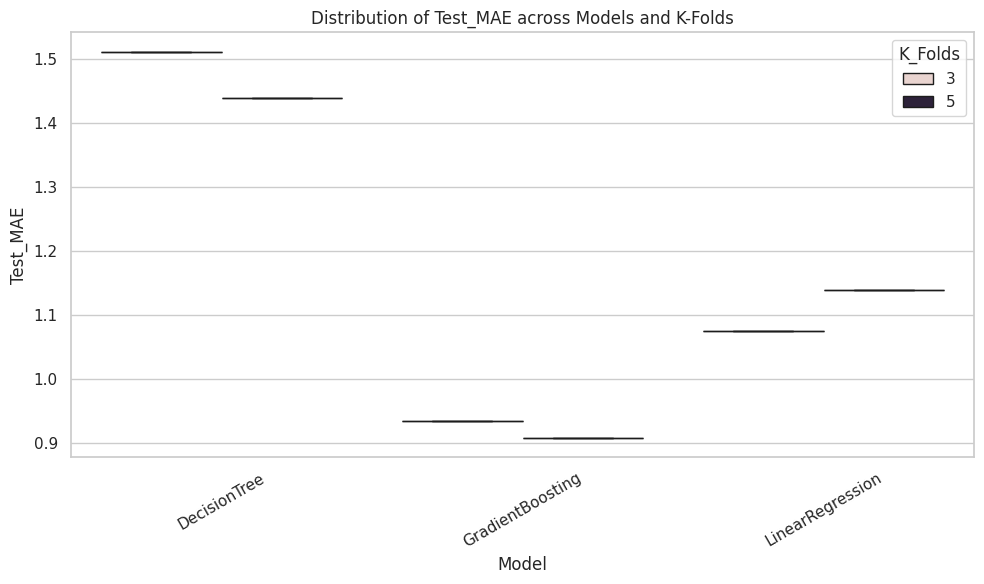

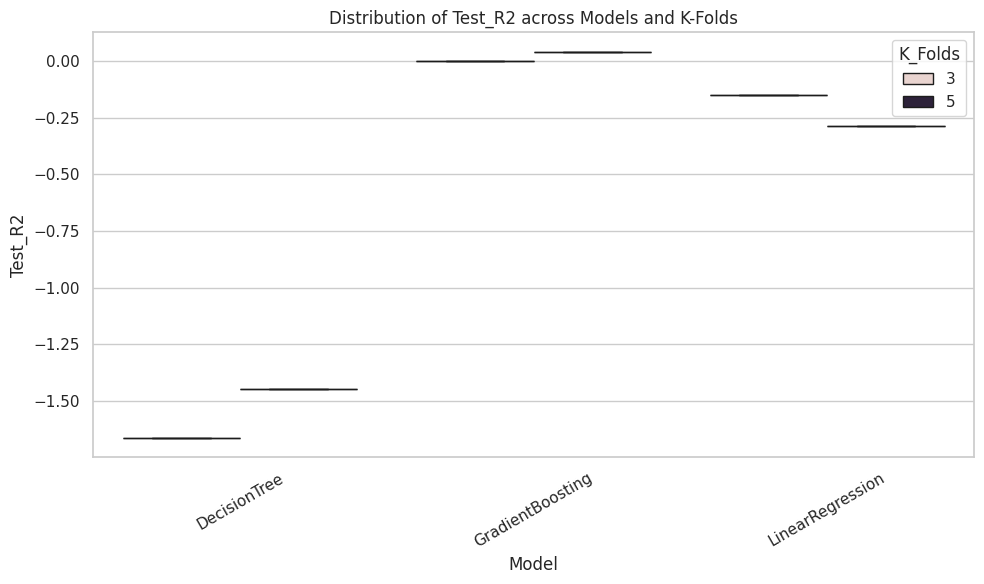

In [25]:
# 4. Boxplots for all metrics
metrics = ['Test_MSE', 'Test_MAE', 'Test_R2']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=summary_df, x='Model', y=metric, hue='K_Folds')
    plt.title(f'Distribution of {metric} across Models and K-Folds')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

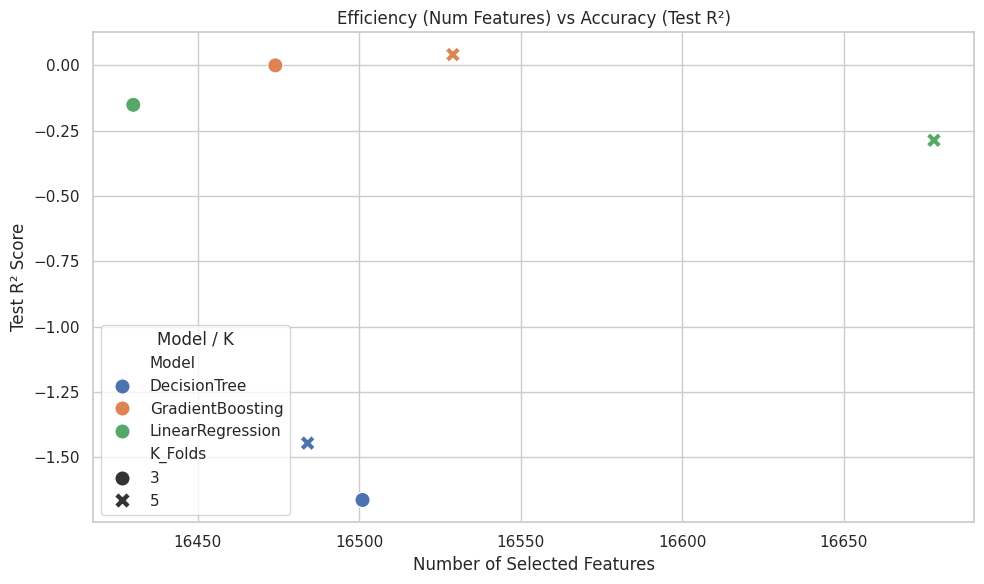

In [26]:
# 5. Efficiency (Num Features) vs Accuracy (Test R²)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x='Num_Features', y='Test_R2', hue='Model', style='K_Folds', s=120)
plt.title("Efficiency (Num Features) vs Accuracy (Test R²)")
plt.xlabel("Number of Selected Features")
plt.ylabel("Test R² Score")
plt.legend(title='Model / K')
plt.tight_layout()
plt.show()

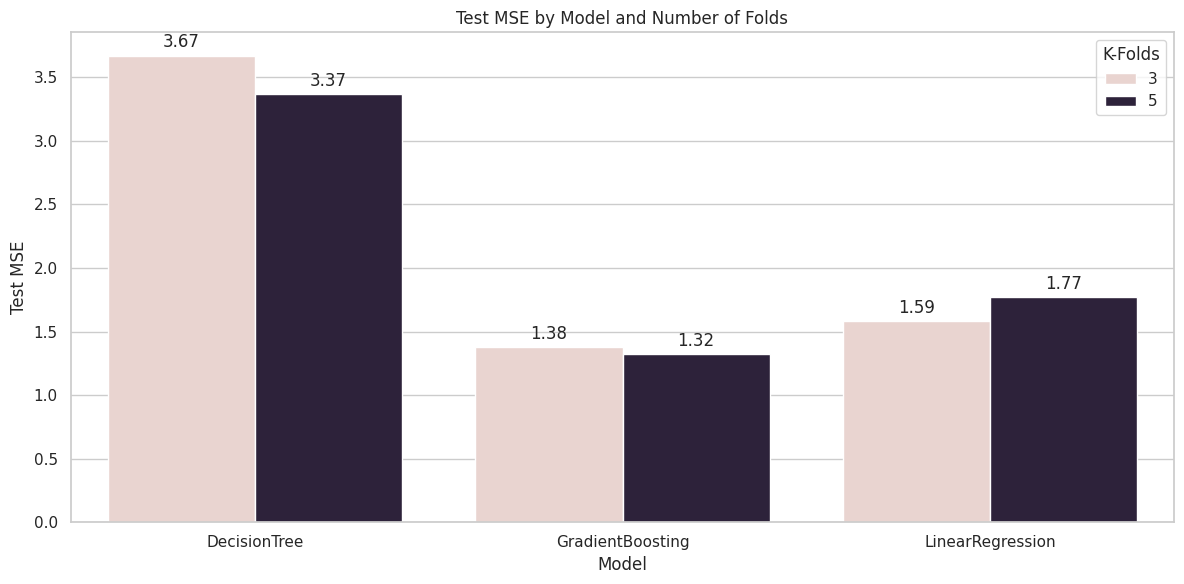

In [27]:
# 6. Test MSE by Model and K-Folds
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=summary_df, x='Model', y='Test_MSE', hue='K_Folds')
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)
plt.title('Test MSE by Model and Number of Folds')
plt.ylabel('Test MSE')
plt.xlabel('Model')
plt.legend(title='K-Folds')
plt.tight_layout()
plt.show()

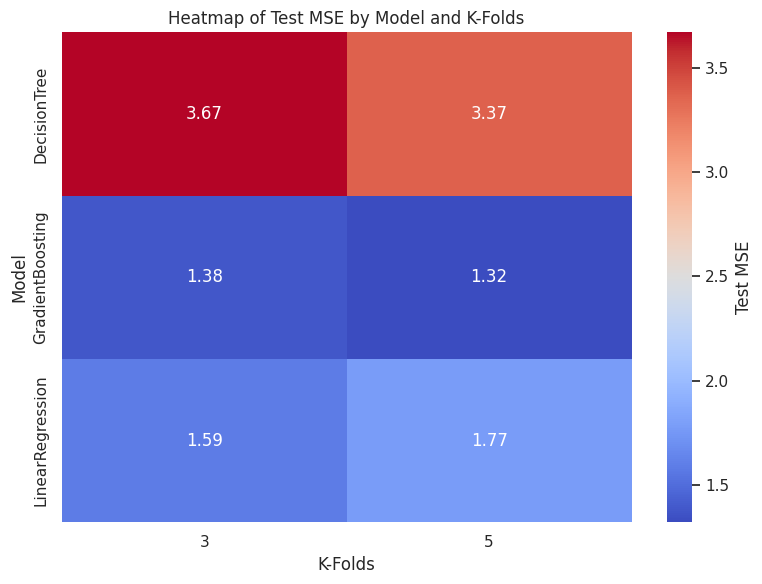

In [28]:
# 7. Heatmap of Test MSE
pivot_mse = summary_df.pivot(index="Model", columns="K_Folds", values="Test_MSE")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_mse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Test MSE'})
plt.title("Heatmap of Test MSE by Model and K-Folds")
plt.ylabel("Model")
plt.xlabel("K-Folds")
plt.tight_layout()
plt.show()

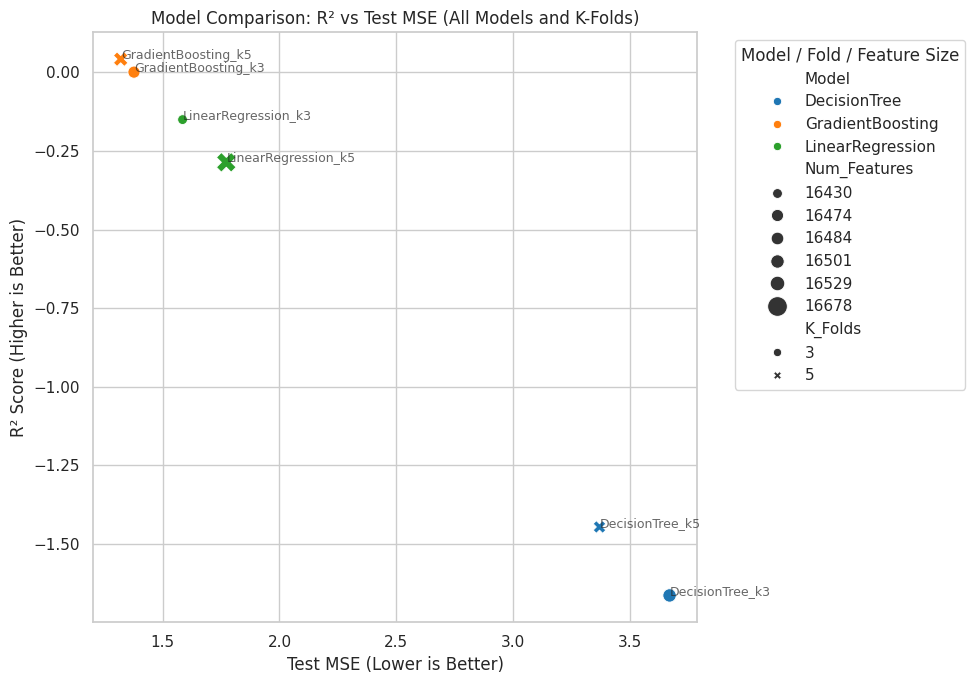

In [29]:
# 8. Scatter Plot (R² vs Test MSE) with All Models and K-Folds
plt.figure(figsize=(10, 7))
sns.set(style='whitegrid')

# Add hue for model, style for k-folds, and size for number of selected features
scatter = sns.scatterplot(
    data=summary_df,
    x='Test_MSE',
    y='Test_R2',
    hue='Model',
    style='K_Folds',
    size='Num_Features',
    sizes=(50, 200),
    palette='tab10'
)

# Add text labels for clarity
for idx, row in summary_df.iterrows():
    plt.text(
        row['Test_MSE'] + 0.001,
        row['Test_R2'],
        f"{row['Model']}_k{row['K_Folds']}",
        fontsize=9,
        alpha=0.7
    )

plt.title('Model Comparison: R² vs Test MSE (All Models and K-Folds)')
plt.xlabel('Test MSE (Lower is Better)')
plt.ylabel('R² Score (Higher is Better)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model / Fold / Feature Size')
plt.tight_layout()
plt.grid(True)
plt.show()
